# Receiving and processing satellite data

The notebook explain how to decode data from the NOAA weather satellites (NOAA 15, NOAA 18 and NOAA 19).
The satellite use the Automatic Picture Transmission (APT) protocol and can be easily received using a (relatively inexpensive) software-defined radio and antenna for 137 MHz (following for example these instructions).


In [78]:
using Images
using FileIO
import APTDecoder
import SatelliteToolbox
using Statistics
using PyPlot
import DSP

Download a sample data file. Note the file name containts the date and time (in UTC) of the recording as well as the center frequency in Hz.

In [79]:
# file name as recorde by gqrx
wavname = "gqrx_20190825_182745_137620000.wav"
download("https://archive.org/download/gqrx_20190825_182745_137620000/gqrx_20190825_182745_137620000.wav",wavname)

"gqrx_20190825_182745_137620000.wav"

Name of the satellite, as used by www.celestrak.com

In [ ]:
satellite_name = "NOAA 15"

Load the satellite orbit information [TLE](https://en.wikipedia.org/wiki/Two-line_element_set)

In [99]:
tles = SatelliteToolbox.read_tle("weather-20190825.txt")

54-element Array{SatelliteToolbox.TLE,1}:
 TLE: DMSP 5D-2 F14 (USA 131) (Epoch = 2019-08-25T12:12:47)
 TLE: NOAA 15 (Epoch = 2019-08-25T13:13:48)                
 TLE: DMSP 5D-3 F15 (USA 147) (Epoch = 2019-08-25T13:40:21)
 TLE: METEOSAT-8 (MSG-1) (Epoch = 2019-08-25T15:21:17)     
 TLE: DMSP 5D-3 F16 (USA 172) (Epoch = 2019-08-25T13:05:08)
 TLE: NOAA 18 (Epoch = 2019-08-25T13:41:26)                
 TLE: METEOSAT-9 (MSG-2) (Epoch = 2019-08-25T07:04:21)     
 TLE: HIMAWARI-7 (MTSAT-2) (Epoch = 2019-08-24T21:38:20)   
 TLE: FORMOSAT-3 FM6 (Epoch = 2019-08-25T12:52:06)         
 TLE: FORMOSAT-3 FM1 (Epoch = 2019-08-24T11:55:52)         
 TLE: FORMOSAT-3 FM5 (Epoch = 2019-08-24T22:26:26)         
 TLE: FORMOSAT-3 FM3 (Epoch = 2019-08-25T12:12:34)         
 TLE: FORMOSAT-3 FM4 (Epoch = 2019-08-25T12:02:03)         
 ⋮                                                         
 TLE: CYGFM01 (Epoch = 2019-08-24T22:10:18)                
 TLE: CYGFM08 (Epoch = 2019-08-24T22:20:31)               

In [80]:
# load the wav file
y,Fs,nbits,opt = FileIO.load(wavname)

([-0.0024719992675557726 -0.0024719992675557726; -0.001098666341135899 -0.001098666341135899; … ; -0.007324442274239326 -0.007324442274239326; -0.003326517532883694 -0.003326517532883694], 48000.0f0, 0x0010, WAV.WAVChunk[WAV.WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x02, 0x00, 0x80, 0xbb, 0x00, 0x00, 0x00, 0xee, 0x02, 0x00, 0x04, 0x00, 0x10, 0x00])])

In [125]:
size(y)

(18549922, 2)

In [101]:
Fs


48000.0f0

Duration in minutes

In [123]:
@show size(y,1) / (Fs*60)

size(y, 1) / (Fs * 60) = 6.440945f0


6.440945f0

In [107]:
1/(20/Fs)

2400.0f0

In [129]:
y[(0:10) .+ 10000,:]

11×2 Array{Float64,2}:
 -0.00433363  -0.00433363
 -0.00244148  -0.00244148
  0.00173956   0.00173956
  0.00595111   0.00595111
  0.00909452   0.00909452
  0.00735496   0.00735496
  0.00598163   0.00598163
  0.0106815    0.0106815 
  0.0117191    0.0117191 
  0.00668355   0.00668355
  0.00543229   0.00543229

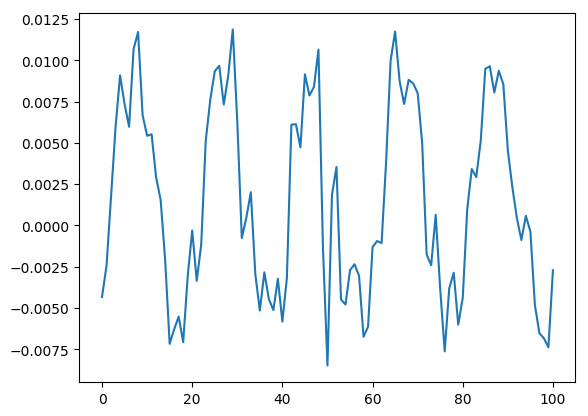

In [130]:
plot(y[(0:100) .+ 10000,1]);

We see a signal with a periodicity of about 20 samples, which correspond to a frequency (in Hz) of:

In [110]:

Fs/20

2400.0f0

2400 Hz is the carrier frequency of the amplitude-modulated signal

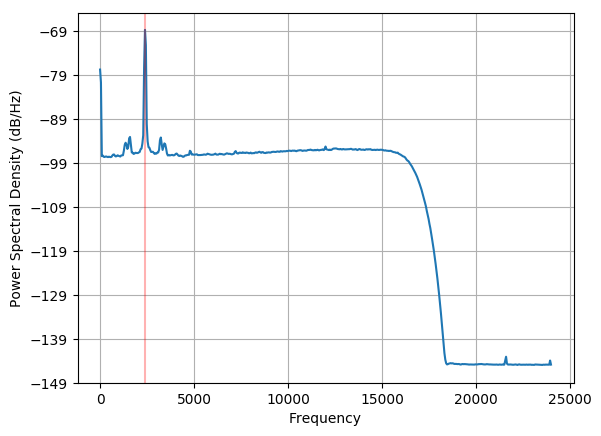

In [119]:
psd(y[:,1],Fs = Fs, NFFT=1024)
axvline(x=2400,color="r",alpha = 0.3);


12480

low and high frequency for the band-pass filter (in Hz)

In [85]:
wpass = (400., 4400.)

(400.0, 4400.0)

In [86]:
responsetype = DSP.Filters.Bandpass(wpass[1],wpass[2],fs = Fs);
designmethod = DSP.Filters.Butterworth(6);

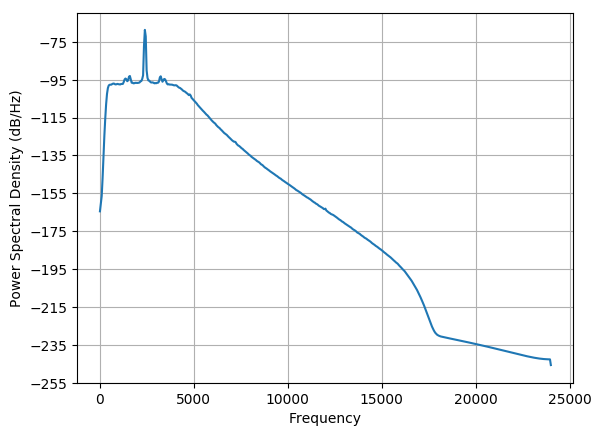

In [87]:
yf = DSP.filt(DSP.digitalfilter(responsetype, designmethod), y[:,1]);
psd(yf[:,1],Fs = Fs, NFFT=1024);

Reduce the frequency by filtering and resampling

In [ ]:
Fs2 = 3*4160

In [88]:
y2 = DSP.Filters.resample(yf, float(Fs2) / float(Fs) );

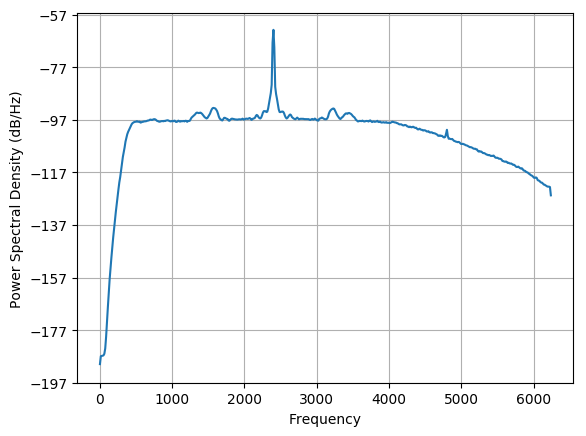

In [89]:
psd(y2,Fs = Fs2, NFFT=1024);


In [90]:
am_demodulation(y2) = abs.(DSP.Util.hilbert(y2))

# AM demodulation using the Hilbert Transform
y_demod = am_demodulation(y2);


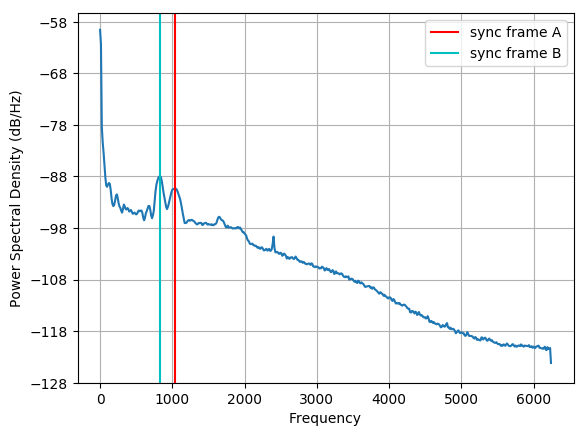

In [91]:
psd(y_demod,Fs = Fs2, NFFT=1024)
axvline(x=1040,label="sync frame A",color="r")
axvline(x=832,label="sync frame B",color="c")
legend();

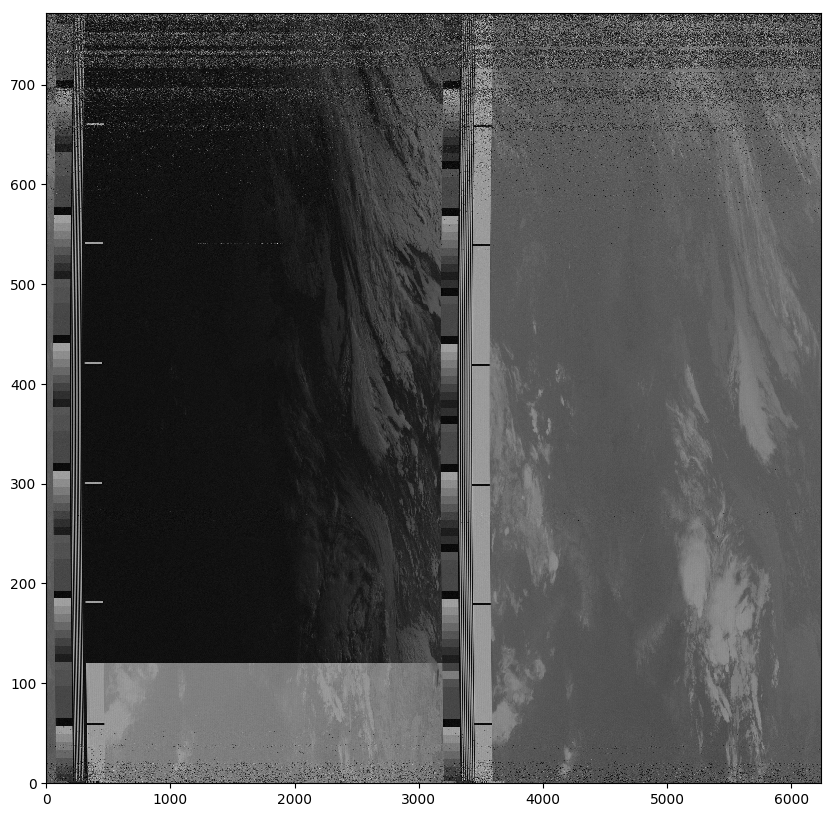

In [92]:
scans_per_seconds = 2    
# length of a frame
frame_len = round(Int,Fs2/scans_per_seconds)
nscan = length(y_demod) ÷ frame_len

figure(figsize=(10,10))
imshow(reshape(y_demod[1:frame_len*nscan],(frame_len,nscan))', aspect="auto", cmap="gray");
gca().invert_yaxis()

In [93]:
# decode to image
datatime,(channelA,channelB),data = APTDecoder.decode(y,Fs)

vmin,vmax = quantile(view(data,:),[0.01,0.99])
data[data .> vmax] .= vmax;
data[data .< vmin] .= vmin;

rawname = replace(wavname,r".wav$" => "_raw.png")
FileIO.save(rawname, colorview(Gray, data[:,1:3:end]./maximum(data)))

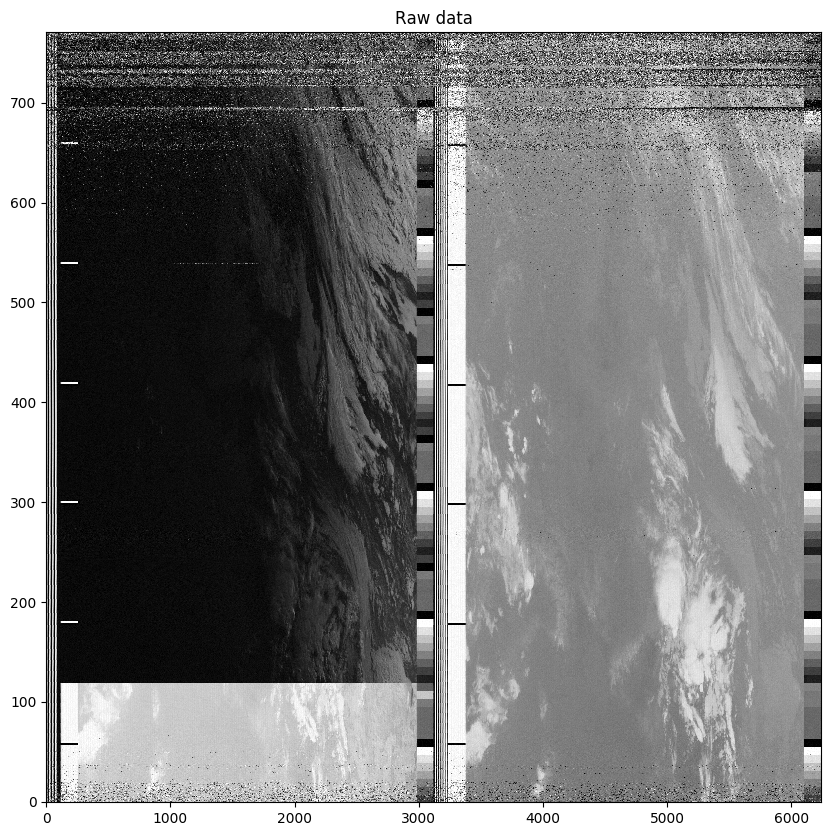

In [94]:
figure("APTDecoder",figsize = (10,10))
imshow(data, aspect="auto", cmap="gray");
gca().invert_yaxis()
title("Raw data");

In [95]:
starttime = APTDecoder.starttimename(wavname)

# TLEs are downloaded if omited
Alon,Alat,Adata = APTDecoder.georeference(channelA,satellite_name,datatime,starttime; tles=tles);

┌ Info: Downloading file 'EOP_IAU1980.TXT' from 'https://datacenter.iers.org/data/latestVersion/223_EOP_C04_14.62-NOW.IAU1980223.txt' with cURL.
└ @ RemoteFiles /home/abarth/.julia/packages/RemoteFiles/Suit7/src/download.jl:53


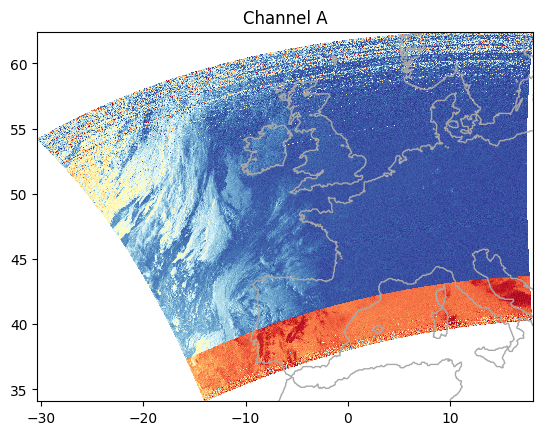

In [96]:
APTDecoder.plot(Alon,Alat,Adata)
title("Channel A");

┌ Info: Downloading file 'EOP_IAU1980.TXT' from 'https://datacenter.iers.org/data/latestVersion/223_EOP_C04_14.62-NOW.IAU1980223.txt' with cURL.
└ @ RemoteFiles /home/abarth/.julia/packages/RemoteFiles/Suit7/src/download.jl:53


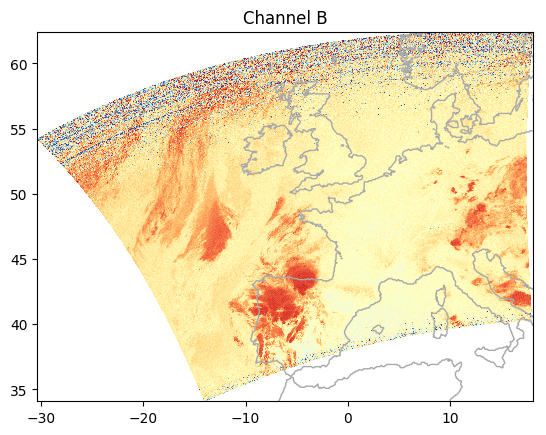

In [97]:
Blon,Blat,Bdata = APTDecoder.georeference(channelB,satellite_name,datatime,starttime; tles=tles)
APTDecoder.plot(Blon,Blat,Bdata)
title("Channel B");

## References

https://en.wikipedia.org/wiki/Automatic_picture_transmission